## Spatial Hierarchical Indexing for Nearest Neighbor Query (NNQ)

Objective of this notebook is to explore Uber H3 Index with DuckDB.
<br>

In [ ]:

%pip install duckdb
%pip install geopandas
%pip install tabulate
%pip install matplotlib
%pip install contextily

In [ ]:
import duckdb
import h3
import folium
#from shapely.geometry import MultiPolygon, Polygon
from IPython.display import display
import pandas as pd
import json
#from prompt_toolkit.formatted_text import to_plain_text

Read restaurant locations

In [ ]:
filename="./restaurants.json"
lines=[]
N=5000
with open(filename, 'r') as infile:
    lines = [line for line in infile][:N]
#print(lines)

for line in lines:
    json_line = json.loads(line)
    #print(f"name: {json_line['name']} , location: {json_line['location']['coordinates']}")

# Define DataFrame
df = pd.DataFrame(columns=["Name", "Lon", "Lat"])

# Parse each line and add to DataFrame
for line in lines:
    json_line = json.loads(line)
    df.loc[len(df)]={"Name":json_line['name'], "Lon":json_line['location']['coordinates'][0], "Lat":json_line['location']['coordinates'][1] }

#from tabulate import tabulate
#print(tabulate(df, headers = 'keys', tablefmt = 'psql'))
df.head(10)



Store restaurant data set into CSV file so that we can upload to DuckDB

In [ ]:
df.to_csv("./restaurants.csv",index=False)

In [ ]:
from os import listdir
from os.path import isfile, join
mypath="./"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f.endswith(".csv")]
onlyfiles

In [ ]:
def listFilesInWithExtension(target_path, target_ext=".csv"):
    if target_path:
        return [f for f in listdir(target_path) if isfile(join(target_path, f)) and f.endswith(target_ext)]
    else:
        return None

In [ ]:
duckdb.sql("SELECT 'whistling_duck' AS waterfowl, 'whistle' AS call")

Let's load restaurants.csv file as a table to food-delivery.db

In [ ]:
with duckdb.connect(database="food-delivery.db") as conn:
    conn.read_csv("./restaurants.csv").to_table("restaurants")
    conn.close()


Validate that DuckDB created .db file

In [ ]:
listFilesInWithExtension("./",target_ext=".db")

Validate restaurants table

In [ ]:
answer=None

with duckdb.connect(database="food-delivery.db") as conn:
    answer=conn.sql("SELECT * FROM restaurants")
    conn.close()


In [ ]:
con = duckdb.connect('food-delivery.db')

results = con.sql("SHOW ALL TABLES").fetchall()
print(type(results))
for result in results:
    print(result)

results = con.sql("SELECT Name, Lon, Lat FROM restaurants").fetchall()
print(type(results))
for result in results:
    print(result)

Let's add new geom column to restaurants table.
<br> ST_Transform()
<br> ST_Point()



Installs and Loads spatial
<br>Adds new geom column to restaurants table.

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = """
INSTALL spatial; LOAD spatial;
ALTER TABLE restaurants ADD COLUMN geom GEOMETRY;
"""
con.sql(query)

Update geom column values from lat and lon columns by using ST_Point.


In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = """
UPDATE restaurants
    SET geom = ST_Point(lat, lon);
"""
con.sql(query)

Let's retrieve the name and location of restaurants

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name, Lon, Lat, geom FROM restaurants;
"""
df_select = con.sql(query).df()

Let's display 10 rows

In [ ]:
df_select[:10]

The following functions are helpers for visualization
<br>vis_add_circle() adds a circle [center:(lat,lon), radius:r] to folium.Map
<br>visualize_poi() adds point of interests to folium.Map
<br>

In [240]:
def vis_add_circle(mymap, lat, lon, r,color="cornflowerblue"):
    circle = folium.CircleMarker(
                location=[lat, lon],
                radius=r,
                color=color,
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                opacity=1,
                popup="{} pixels".format(r),
                tooltip="I am NNQ",
    )
    mymap.add_child(circle)


def visualize_poi(df_selected, nnq_lon=None, nnq_lat=None, radius=10, color="red"):
    """
    Visualize  by using folium map

    :param df_selected:
    :param nnq_lon:
    :param nnq_lat:
    :param radius:
    :param color:
    :return:
    """

    fm_map = folium.Map(location=[sum(df_selected.Lat)/len(df_selected.Lat), sum(df_selected.Lon)/len(df_selected.Lon)], zoom_start=10, tiles='Cartodb Positron')
    if nnq_lat and nnq_lon:
        vis_add_circle(fm_map, nnq_lat, nnq_lon, radius, color="red")
    #my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    #m.add_child(my_PolyLine)
    for index, row in df.iterrows():
        r=2
        circle = folium.CircleMarker(
                location=[row['Lat'], row['Lon']],
                radius=r,
                color="cornflowerblue",
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                opacity=1,
                popup="{} pixels".format(r),
                tooltip=row['Name'],
            )
        fm_map.add_child(circle)

    return m


Let's see the locations on a map

In [ ]:
m = visualize_poi(df_select,None,None)
display(m)

If it does not display the map, here it is.
![](./md-1.png)

## NNQ Query
<br> Let's define a NNQ with center location and distance (radius)

In [ ]:
NNQ_LON=-73.8601152
NNQ_LAT= 40.7311739
NNQ_RADIUS = 110


LLet's see the NNQ on the map with restaurants

In [ ]:
m = visualize_poi(df_select, NNQ_LON, NNQ_LAT, NNQ_RADIUS*0.005)
display(m)

The circle in red denotes the range of query.
<br>If it does not display the map, here it is.
![](./md-2.png)

Let's find the distance between query center and each restaurant.
<br>This query has to scan the table.

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name
    , Lon
    , Lat
    , ST_Distance(geom, ST_Point({NNQ_LON}, {NNQ_LAT})) AS dist2NNQ
FROM restaurants
"""
df_select = con.sql(query).df()

Let's sort these and display

In [ ]:
df_select.sort_values(by='dist2NNQ', ascending=True, inplace=True)
df_select

Let's find restaurant locations without any index.
<br>It uses ST_DWithin() spatial function to select the locations within the radius.

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {NNQ_RADIUS}*0.016195);
"""
df_select = con.sql(query).df()

In [ ]:
df_select

In [ ]:
m = visualize_poi(df_select, NNQ_LON, NNQ_LAT, NNQ_RADIUS*0.005)
display(m)

<br>If it does not display the map, here it is.
![](./md-3.png)

## No Index
Let's analyze the query plan to verify table scan

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
EXPLAIN ANALYZE
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {NNQ_RADIUS}*1.4734);
"""
query_plan = con.sql(query).fetchall()

In [ ]:
analyzed_plan = query_plan[0][1]

for line in analyzed_plan.split('\n'):
    print(line)

with open('./qa_st_dwithin.txt', 'w', encoding="utf-8") as f:
    f.writelines(analyzed_plan)
    f.close()


As the query plan shows, it scans the table sequentially (Type: Sequential Scan). The time complexity is O(N) where N is the number of restaurants in the table.
<br> It is suitable for sharding and applying scatter-gather query. In that case the time complexity will be O(N/S) (following Amhdal's Law). Gatherer/broker needs to apply multi-way merge sort before returning the final query result.
<br> Here is the output image.<br>
![](md-4.png)
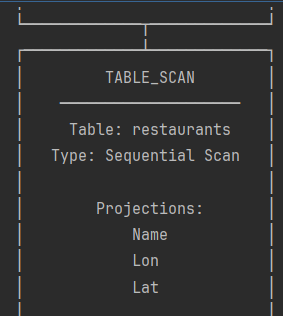

## R-Tree Index
Let's use R-Tree index on geom column.

In [ ]:
%%time
query = "CREATE INDEX spatial_index_rtree ON restaurants USING RTREE (geom);"
con.sql(query)


In [ ]:
# \TODO Fix mapping to spherical coordinate system
MNNQ_RADIUS = (NNQ_RADIUS*1.4734)*0.7075

Let's define a bounding box around the (center, radius) so that it can be used in the query to utilize R-Tree index.
<br> GEOMETRY ST_MakeEnvelope (min_x DOUBLE, min_y DOUBLE, max_x DOUBLE, max_y DOUBLE)
<br> \TODO ST_MaximumInscribedCircle

In [ ]:
%%time
query = f"SELECT ST_MakeEnvelope({NNQ_LON}-{MNNQ_RADIUS}, {NNQ_LAT}-{MNNQ_RADIUS},{NNQ_LON}+{MNNQ_RADIUS}, {NNQ_LAT}+{MNNQ_RADIUS}) AS envelope;"
dfr = con.sql(query).df()
dfr

Query engine will consider R-Tree index if the predicates (conditions in WHERE clause) have one of the following spatial operations<br>
 - ST_Equals
 - ST_Intersects
 - ST_Touches
 - ST_Crosses
 - ST_Within
 - ST_Contains
 - ST_Overlaps
 - ST_Covers
 - ST_CoveredBy
 - ST_ContainsProperly


This implementation is based on ST_Within() function
<br>
<br>BOOLEAN ST_Within (geom1 POINT_2D, geom2 POLYGON_2D)
<br>BOOLEAN ST_Within (geom1 GEOMETRY, geom2 GEOMETRY)
<br>
<br> reference: https://duckdb.org/docs/stable/core_extensions/spatial/functions#st_within

In [241]:
MNNQ_RADIUS = NNQ_RADIUS * 0.011455
print(" %16.12f" % MNNQ_RADIUS)

 114.550000000000


In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SET VARIABLE envelope = ST_MakeEnvelope({NNQ_LON}-{MNNQ_RADIUS}, {NNQ_LAT}-{MNNQ_RADIUS},{NNQ_LON}+{MNNQ_RADIUS}, {NNQ_LAT}+{MNNQ_RADIUS});
SELECT name, Lon, Lat
FROM restaurants
WHERE ST_Within(geom,getvariable('envelope'));
"""
df_select = con.sql(query).df()

In [ ]:
df_select

Let's analyze the query plan

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SET VARIABLE envelope = ST_MakeEnvelope({NNQ_LON}-{MNNQ_RADIUS}, {NNQ_LAT}-{MNNQ_RADIUS},{NNQ_LON}+{MNNQ_RADIUS}, {NNQ_LAT}+{MNNQ_RADIUS});

EXPLAIN ANALYZE
SELECT name, Lon, Lat
FROM restaurants
WHERE ST_Within(geom, getvariable('envelope'));
--WHERE ST_Contains(getvariable('envelope'),geom);
"""
query_plan = con.sql(query).fetchall()

In [ ]:
analyzed_plan = query_plan[0][1]

for line in analyzed_plan.split('\n'):
    print(line)

with open('./qa_st_dwithin_rtree.txt', 'w', encoding="utf-8") as f:
    f.writelines(analyzed_plan)
    f.close()

Now, it uses Index: spatial_index_rtree when scanning the table.
<br> here is part of analysis<br>
![](md-5.png)

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
SELECT name, Lon, Lat
FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {MNNQ_RADIUS});
"""
df_select = con.sql(query).df()

In [ ]:
df_select

In [ ]:
%%time
con = duckdb.connect('food-delivery.db')
query = f"""
EXPLAIN ANALYZE
SELECT name, Lon, Lat FROM restaurants
WHERE ST_DWithin(geom, ST_Point({NNQ_LON}, {NNQ_LAT}), {MNNQ_RADIUS});
"""
query_plan = con.sql(query).fetchall()

In [ ]:
analyzed_plan = query_plan[0][1]

for line in analyzed_plan.split('\n'):
    print(line)

with open('./qa_st_dwithin_rtree.txt', 'w', encoding="utf-8") as f:
    f.writelines(analyzed_plan)
    f.close()

Because ST_DWithin() function does not exploit R-Tree index, query falls back to sequential scan.

## H3 Index


Let's drop the R-Tree index on geom column.

In [ ]:
con = duckdb.connect('food-delivery.db')
query = """
DROP INDEX IF EXISTS spatial_index_rtree;"""
con.sql(query)

Let's install h3

In [ ]:
query = """
INSTALL h3 FROM community; LOAD h3;"""
con.sql(query)

Let's add a column to restaurants table to store H3 Cell Identifier..
<br>
<br>h3_latlng_to_cell(Lat, Lon, RESOLUTION): Returns the H3 Cell Identifier of location(Lat,Lon) at given RESOLUTION level

In [ ]:
%%time
RESOLUTION=7
query = f"""
ALTER TABLE restaurants ADD COLUMN IF NOT EXISTS h3_cell_id BIGINT;
UPDATE restaurants
  SET h3_cell_id = h3_latlng_to_cell(Lat, Lon, {RESOLUTION});
CREATE INDEX spatial_index_h3 ON restaurants (h3_cell_id)"""
con.sql(query)

Let's see how H3 Cells are organized

In [ ]:
RESOLUTION = 7
NNQ_RADIUS = 10000

h3_cell = h3.latlng_to_cell(NNQ_LAT, NNQ_LON, RESOLUTION)
print(f" LAT:{NNQ_LAT} LON:{NNQ_LON} resolution:{RESOLUTION} -> {h3_cell}")

h3_neighbors = h3.grid_disk(h3_cell, 1)  # Center + 1st ring
print(type(h3_neighbors))
h3_neighbors

h3.grid_disk(h3_cell, 1) returns the first layer of H3 Cells surrounding the h3_cell.
<br>Let's validate that it will produce the same when used in SQL

In [ ]:
%%time
query = f"""
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3_cell_id
  FROM query_h3
)
SELECT * FROM nearby_h3;
"""
df_select = con.sql(query).df()

In [ ]:
df_select

The values do not look like the hexadecimal H3 Cell Id we have seen.

In [ ]:
print(f" Type(df_select)  : {type(df_select)}")
print(f" Shape(df_select) : {df_select.shape}")
print(df_select.dtypes)

The data type of h_cell_id is int64.
<br>Let's encode these to hexadecimal

In [ ]:
df_select['h3_cell_id_hex'] = df_select['h3_cell_id'].apply(lambda x: hex(x))
df_select

Let's compare side by side with h3_neighors list

In [ ]:
df_select['h3_neighbors'] = pd.DataFrame(h3_neighbors)
df_select

The values in h3_cell_id column we obtained as a result of SQL query.
<br> What is stored in h3_cell_id is uint64 of hexadecimal H3_Cell_Id

In [ ]:
%%time
query = f"""
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3
)
SELECT restaurants.*, nearby_h3.*
FROM restaurants
JOIN nearby_h3 ON restaurants.h3_cell_id = nearby_h3.h3;
"""
df_select = con.sql(query).df()
df_select[:10]

In [ ]:
%%time
query = f"""
EXPLAIN ANALYZE
WITH query_h3 AS (
  SELECT h3_latlng_to_cell({NNQ_LAT}, {NNQ_LON}, {RESOLUTION}) AS h3
),
nearby_h3 AS (
  SELECT CAST(unnest(h3_grid_disk(h3, 1)) AS BIGINT) AS h3 FROM query_h3
)
SELECT restaurants.*, nearby_h3.*
FROM restaurants
JOIN nearby_h3 ON restaurants.h3_cell_id = nearby_h3.h3;
"""
query_plan = con.sql(query).fetchall()

In [ ]:
analyzed_plan = query_plan[0][1]

for line in analyzed_plan.split('\n'):
    print(line)

with open('./qa_h3.txt', 'w', encoding="utf-8") as f:
    f.writelines(analyzed_plan)
    f.close()

The query planner takes advantage of Index Scan.
<br>Output from query plan is
<br>
![](./md-6.png)

## Summary
This notebook studied the spatial indexing solutions for Nearest Neighbor Query (NNQ).
 - As expected, spatial index prevents sequential scan.
 - H3 Cells does not satisfy the containment property between consecuitive resolutions.


## Appendix